In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import math,time,os

In [2]:
def parse_label(path):
    raw = open(path).read()
    classnames =[]
    for cls in raw.split('\n'):
        if cls == '':
            continue
        classnames.append(cls)
    return classnames

def _decode_and_resize(filename, label):
    image_string = tf.io.read_file(filename)  # 读取原始文件
    image_decoded = tf.io.decode_jpeg(image_string,channels=3)  # 解码JPEG图片
    image_resized = tf.image.resize(image_decoded, [224, 224]) / 255.0
    return image_resized, label

def load_data(dirs):
    images_name = []
    labels = []
    for i,file_dir in enumerate(dirs):
        filename = tf.constant([file_dir + '/' + filename for filename in os.listdir(file_dir)])
        images_name = tf.concat([images_name,filename],axis=-1)
        labels = tf.concat([labels,tf.constant(i,shape=filename.shape[0])],axis=-1)
    print("total:%d" %  images_name.shape[0])
    train_dataset = tf.data.Dataset.from_tensor_slices((images_name, labels))
    train_dataset = train_dataset.map(
        map_func=_decode_and_resize,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return train_dataset

num_epochs = 5
batch_size = 10
learning_rate = 0.005
buffer_size=13000

train_dir = './data/test/'
class_names = parse_label(train_dir+'classes_label.txt')
train_file_dirs = [train_dir+classname for classname in class_names] 
train_dataset = load_data(train_file_dirs)
train_dataset = train_dataset.shuffle(buffer_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

total:23536


In [3]:
model = tf.keras.applications.NASNetMobile(weights=None,classes=len(class_names))
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[tf.keras.metrics.sparse_categorical_accuracy]
    )
model.fit(train_dataset,epochs=num_epochs)
model.save('model/NASNetMobile-'+time.strftime("%m-%d-%H-%M", time.localtime())+'.h5')

2354/2354 [==============================] - 925s 337ms/step - loss: 3.2366 - sparse_categorical_accuracy: 0.1043


pre:熟食 	true;口服液瓶
pre:卫生纸 	true;电池
pre:玻璃 	true;口罩
pre:纸箱 	true;尿布
pre:刀 	true;卫生纸
pre:刀 	true;口服液瓶


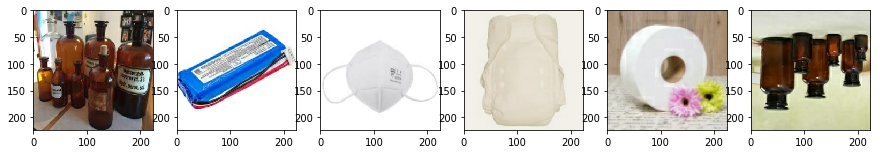

pre:皮带 	true;报纸
pre:卫生纸 	true;卫生纸
pre:口服液瓶 	true;口服液瓶
pre:塑料瓶 	true;玻璃


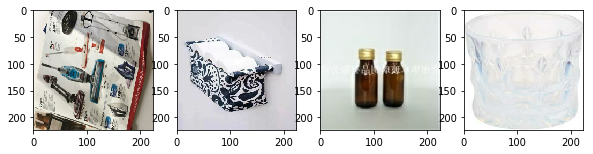

0.2


In [9]:
for images, labels in train_dataset: 
    width,height = 6,math.ceil(batch_size/6.0)
    acc=0
    output = model(images,training=True)
    for i in range(height):
        plt.figure(figsize=(15, 15))
        for j in range(width):
            plt.subplot(1,width,j+1)
#             print(output[i*width+j].numpy())
            index = tf.math.argmax(output[i*width+j]).numpy()
#             print(index)
            true = labels[i*width+j].numpy()
            if index == true:
                acc+=1
            print('pre:%s \ttrue;%s'%(class_names[index],class_names[true]))
#             plt.title(class_names[index]+' ('+class_names[true]+')')
            plt.imshow(images[i*width+j].numpy())
            if i*width+j == batch_size-1:
                    break
        plt.show()
    print(acc/batch_size)
    break